In [19]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys

In [2]:
!pip install prophet
!pip install cmdstanpy

In [20]:

dir = "./data/"
credit = pd.read_csv(dir+"data4columbia_credit.csv")
credit.columns = ['company','date', 'data']
credit.date = pd.to_datetime(credit.date)
pivot_credit = pd.pivot_table(credit, values="data", index="date", columns="company")
pivot_credit = pivot_credit.fillna(0)

#pick one company to work with
data = pd.DataFrame(pivot_credit["dfe2fbf1ed01"])
data = data.replace(to_replace=0, method='ffill')
data

,dfe2fbf1ed01
date,
2016-01-01,181501.8496
2016-01-02,190782.1679
2016-01-03,231482.3076
2016-01-04,246606.3886
2016-01-05,256720.4474
...,...
2022-11-06,891444.9990
2022-11-07,942398.3733
2022-11-08,931085.5098


In [28]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression


mod_kns = MarkovRegression(data["dfe2fbf1ed01"], k_regimes=2, trend='ct', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:           dfe2fbf1ed01   No. Observations:                 2506
Model:               MarkovRegression   Log Likelihood              -32158.203
Date:                Mon, 03 Jul 2023   AIC                          64332.406
Time:                        14:58:14   BIC                          64379.018
Sample:                    01-01-2016   HQIC                         64349.326
                         - 11-10-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.811e+05      0.001   1.49e+08      0.000    1.81e+05    1.81e+05
x1           177.9410      1.747    101.863      0.000     174.517     181.365
sigma2      3.135e+09   8.89e-10   3.53e+18      0.000    3.13e+09    3.13e+09
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.071e+05      0.001   1.82e+08      0.000    2.07e+05    2.07e+05
x1           310.4252      1.979    156.850      0.000     306.546     314.304
sigma2      1.625e+10   8.61e-11   1.89e+20      0.000    1.63e+10    1.63e+10
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        1.0000        nan        nan        nan         nan         nan
p[1->0]        0.0013      0.001      1.001      0.317      -0.001       0.004
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 6.98e+37. Standard errors may be unstable.
"""

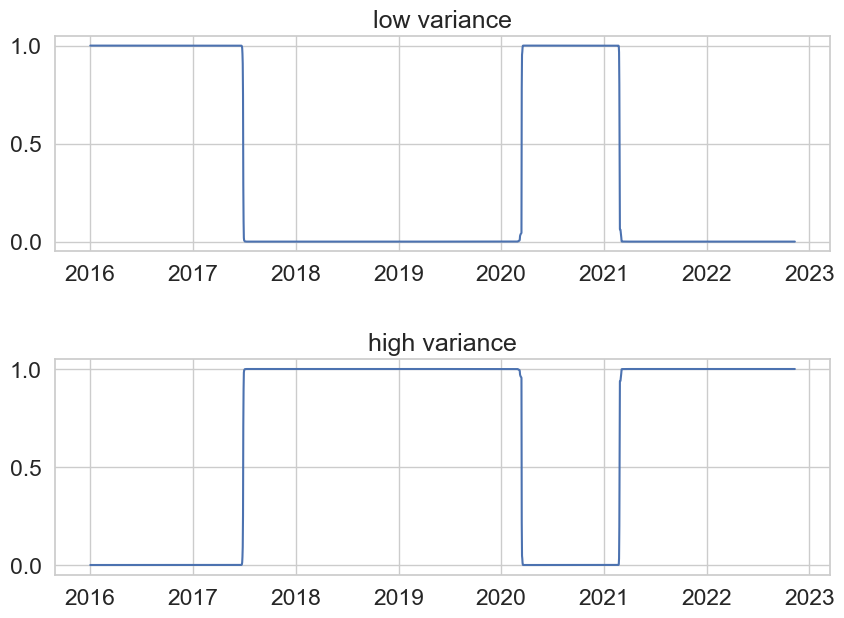

In [29]:
fig, axes = plt.subplots(2, figsize=(10,7))

ax1 = axes[0]
ax1.plot(res_kns.smoothed_marginal_probabilities[0])
ax1.set_title("low variance")

ax2 = axes[1]
ax2.plot(res_kns.smoothed_marginal_probabilities[1])
ax2.set_title("high variance")

plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots vertically


In [30]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [31]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

Text(0.5, 0.98, 'Regime Changes')

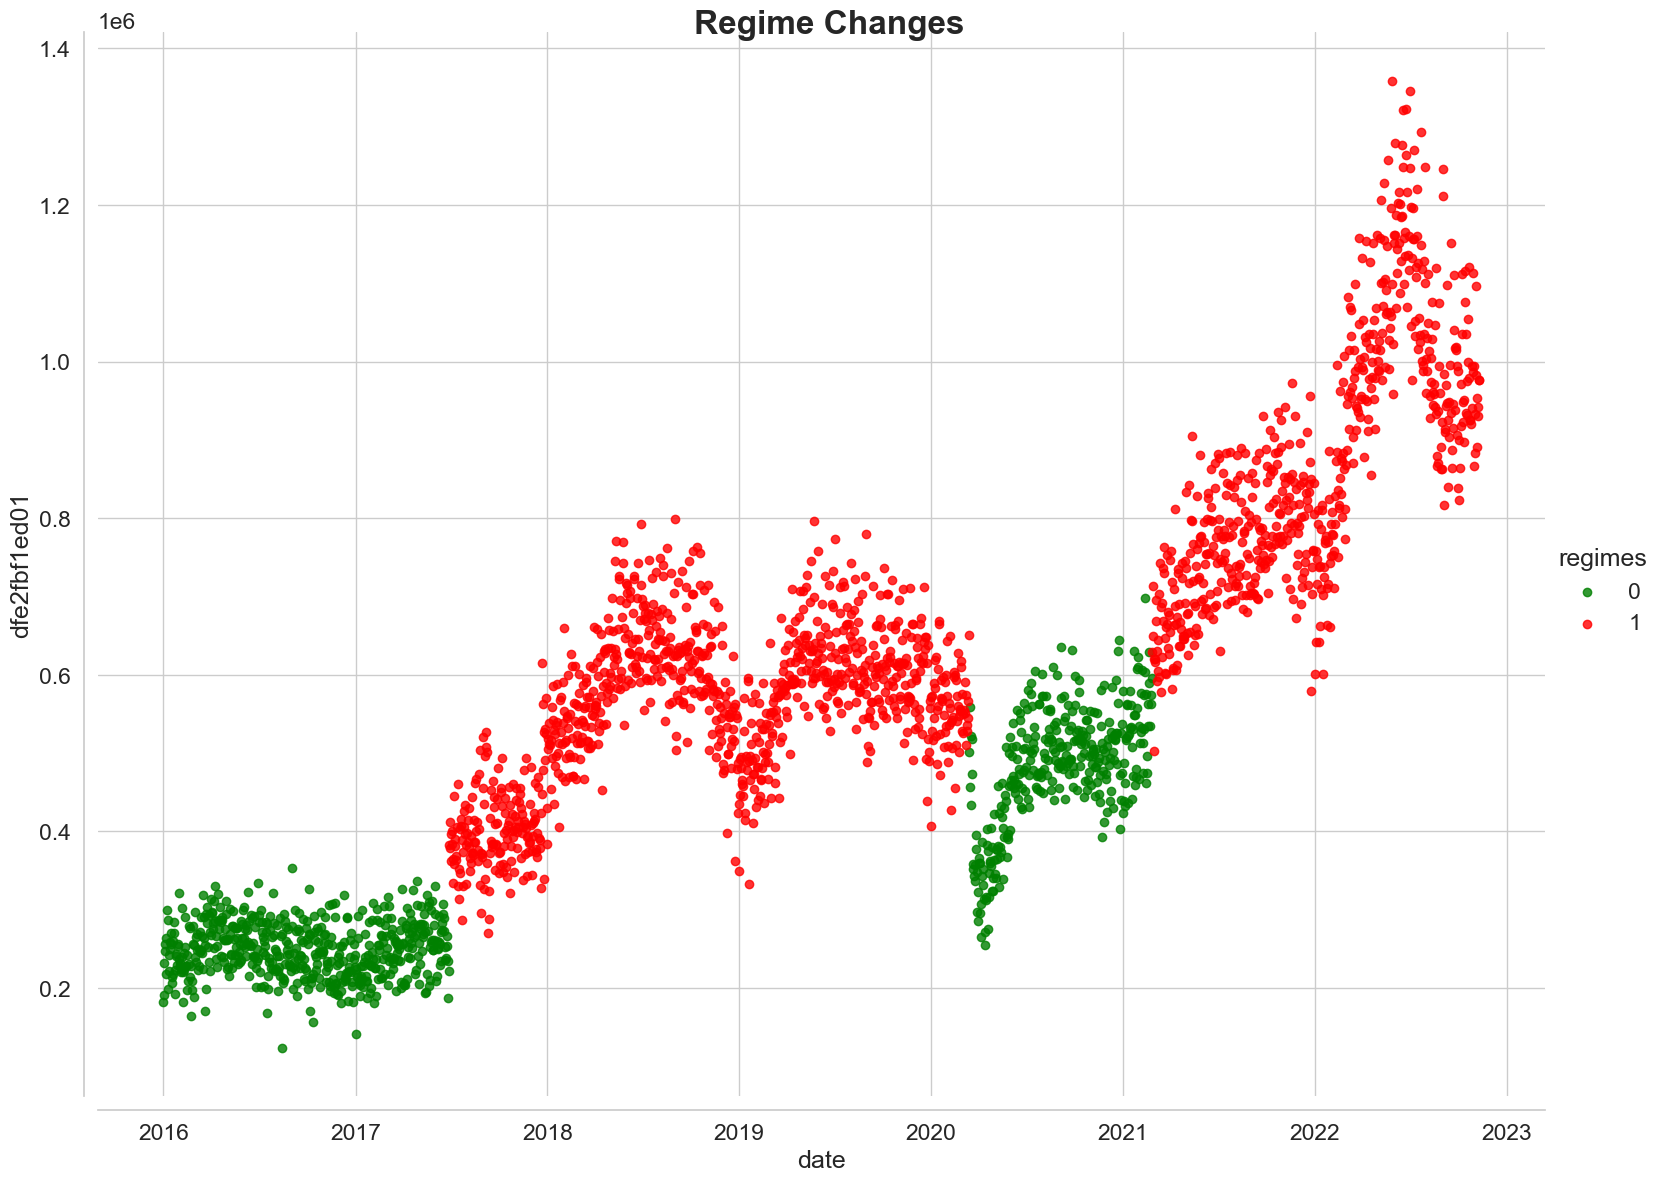

In [32]:
import seaborn as sns

sns.set(font_scale=1.5)
df = data.iloc[len(data)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'date', "dfe2fbf1ed01", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Regime Changes', fontsize=24, fontweight='demi')


In [34]:
low_var_data = regimes[regimes['regimes'] == 0]
high_var_data = regimes[regimes['regimes'] == 1]

In [35]:
import statsmodels.api as sm
from arch import arch_model

# Fit ARIMA model to low variance regime data
low_var_model = sm.tsa.ARIMA(low_var_data['dfe2fbf1ed01'], order=(1, 1, 0))
low_var_results = low_var_model.fit()

# Fit GARCH model to high variance regime data
high_var_model = arch_model(high_var_data['dfe2fbf1ed01'], vol='Garch', p=1, q=0)
high_var_results = high_var_model.fit()


Iteration:      1,   Func. Count:      5,   Neg. LLF: 21561.729998414623
Iteration:      2,   Func. Count:      9,   Neg. LLF: 21555.71581810632
Iteration:      3,   Func. Count:     13,   Neg. LLF: 21538.810935799644
Iteration:      4,   Func. Count:     17,   Neg. LLF: 21538.72034472671
Iteration:      5,   Func. Count:     21,   Neg. LLF: 21538.608773983862
Iteration:      6,   Func. Count:     25,   Neg. LLF: 21538.60840546668
Iteration:      7,   Func. Count:     29,   Neg. LLF: 21538.608398980323
Iteration:      8,   Func. Count:     33,   Neg. LLF: 21538.608376383083
Iteration:      9,   Func. Count:     37,   Neg. LLF: 21538.60824797493
Iteration:     10,   Func. Count:     41,   Neg. LLF: 21538.607976883377
Iteration:     11,   Func. Count:     45,   Neg. LLF: 21538.607613611217
Iteration:     12,   Func. Count:     49,   Neg. LLF: 21538.606287946226
Iteration:     13,   Func. Count:     53,   Neg. LLF: 21538.60313042836
Iteration:     14,   Func. Count:     57,   Neg. LLF: 21

In [39]:
# Forecast for low variance regime
low_var_forecast = low_var_results.forecast(steps=70)

# Forecast for high variance regime
high_var_forecast = high_var_results.forecast(horizon=70)

In [40]:
low_var_forecast

892    590563.446682
893    591703.188246
894    591437.632290
895    591499.505936
896    591485.089584
           ...      
957    591487.813810
958    591487.813810
959    591487.813810
960    591487.813810
961    591487.813810
Name: predicted_mean, Length: 70, dtype: float64